### About the dataset
The data is a marketing campaign using phone calls that a Portuguese bank conducted. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The data is from: https://archive.ics.uci.edu/dataset/222/bank+marketing

The classification goal is to predict if the client will subscribe (yes/no) a term deposit.

### Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month',
         'contact_duration', 'campaign', 'days_since_contact', 'count_prev_contact', 'past_camp_outcome', 'term_deposit' ]

df= pd.read_csv(r'Dataset\bank-full.csv', sep=';', names= cols, header=0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,contact_duration,campaign,days_since_contact,count_prev_contact,past_camp_outcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 45211 non-null  int64 
 1   job                 45211 non-null  object
 2   marital             45211 non-null  object
 3   education           45211 non-null  object
 4   default             45211 non-null  object
 5   balance             45211 non-null  int64 
 6   housing             45211 non-null  object
 7   loan                45211 non-null  object
 8   contact             45211 non-null  object
 9   day_of_week         45211 non-null  int64 
 10  month               45211 non-null  object
 11  contact_duration    45211 non-null  int64 
 12  campaign            45211 non-null  int64 
 13  days_since_contact  45211 non-null  int64 
 14  count_prev_contact  45211 non-null  int64 
 15  past_camp_outcome   45211 non-null  object
 16  term_deposit        45

In [4]:
df.isna().sum()

age                   0
job                   0
marital               0
education             0
default               0
balance               0
housing               0
loan                  0
contact               0
day_of_week           0
month                 0
contact_duration      0
campaign              0
days_since_contact    0
count_prev_contact    0
past_camp_outcome     0
term_deposit          0
dtype: int64

In [5]:
df.contact_duration
# contact duration is the last contact duration between the bank and the client in seconds, where if it's 0 the target variable is no
# the thing is the duration is not known before the call is made so it's an info that we won't have in real life as the client might say 'no thank you I am busy' and close the call
# so I will drop it to prevent possible data leakage if trained on that

0         261
1         151
2          76
3          92
4         198
         ... 
45206     977
45207     456
45208    1127
45209     508
45210     361
Name: contact_duration, Length: 45211, dtype: int64

<Axes: xlabel='term_deposit', ylabel='contact_duration'>

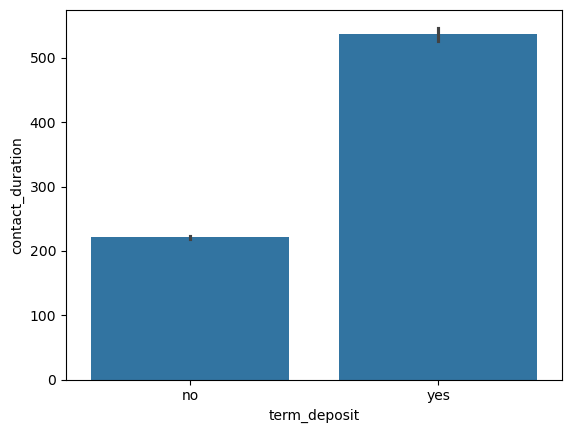

In [6]:
sns.barplot(data= df, y= 'contact_duration' , x= 'term_deposit')

In [7]:
for c in df.columns:
    if df[c].dtype==object:
        print(df[c].value_counts())
        print('___________________________________')

# looking at the job, contact, past_camp_outcome feature looks like I will have to use one hot encoding with it
# martital doesnt actually have inherent odrder to them despite intution so also one hot ecncoding
# education on the otherhand has inherent order to them so I will use label encoding
# default, housing , loan, term_deposit will be handeled with just mapping
# month is tricky because it will impact different learning models differently based on the way I handle it  # tree, XGBoost models would be generally good with these

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
___________________________________
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
___________________________________
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
___________________________________
default
no     44396
yes      815
Name: count, dtype: int64
___________________________________
housing
yes    25130
no     20081
Name: count, dtype: int64
___________________________________
loan
no     37967
yes     7244
Name: count, dtype: int64
___________________________________
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
______________________

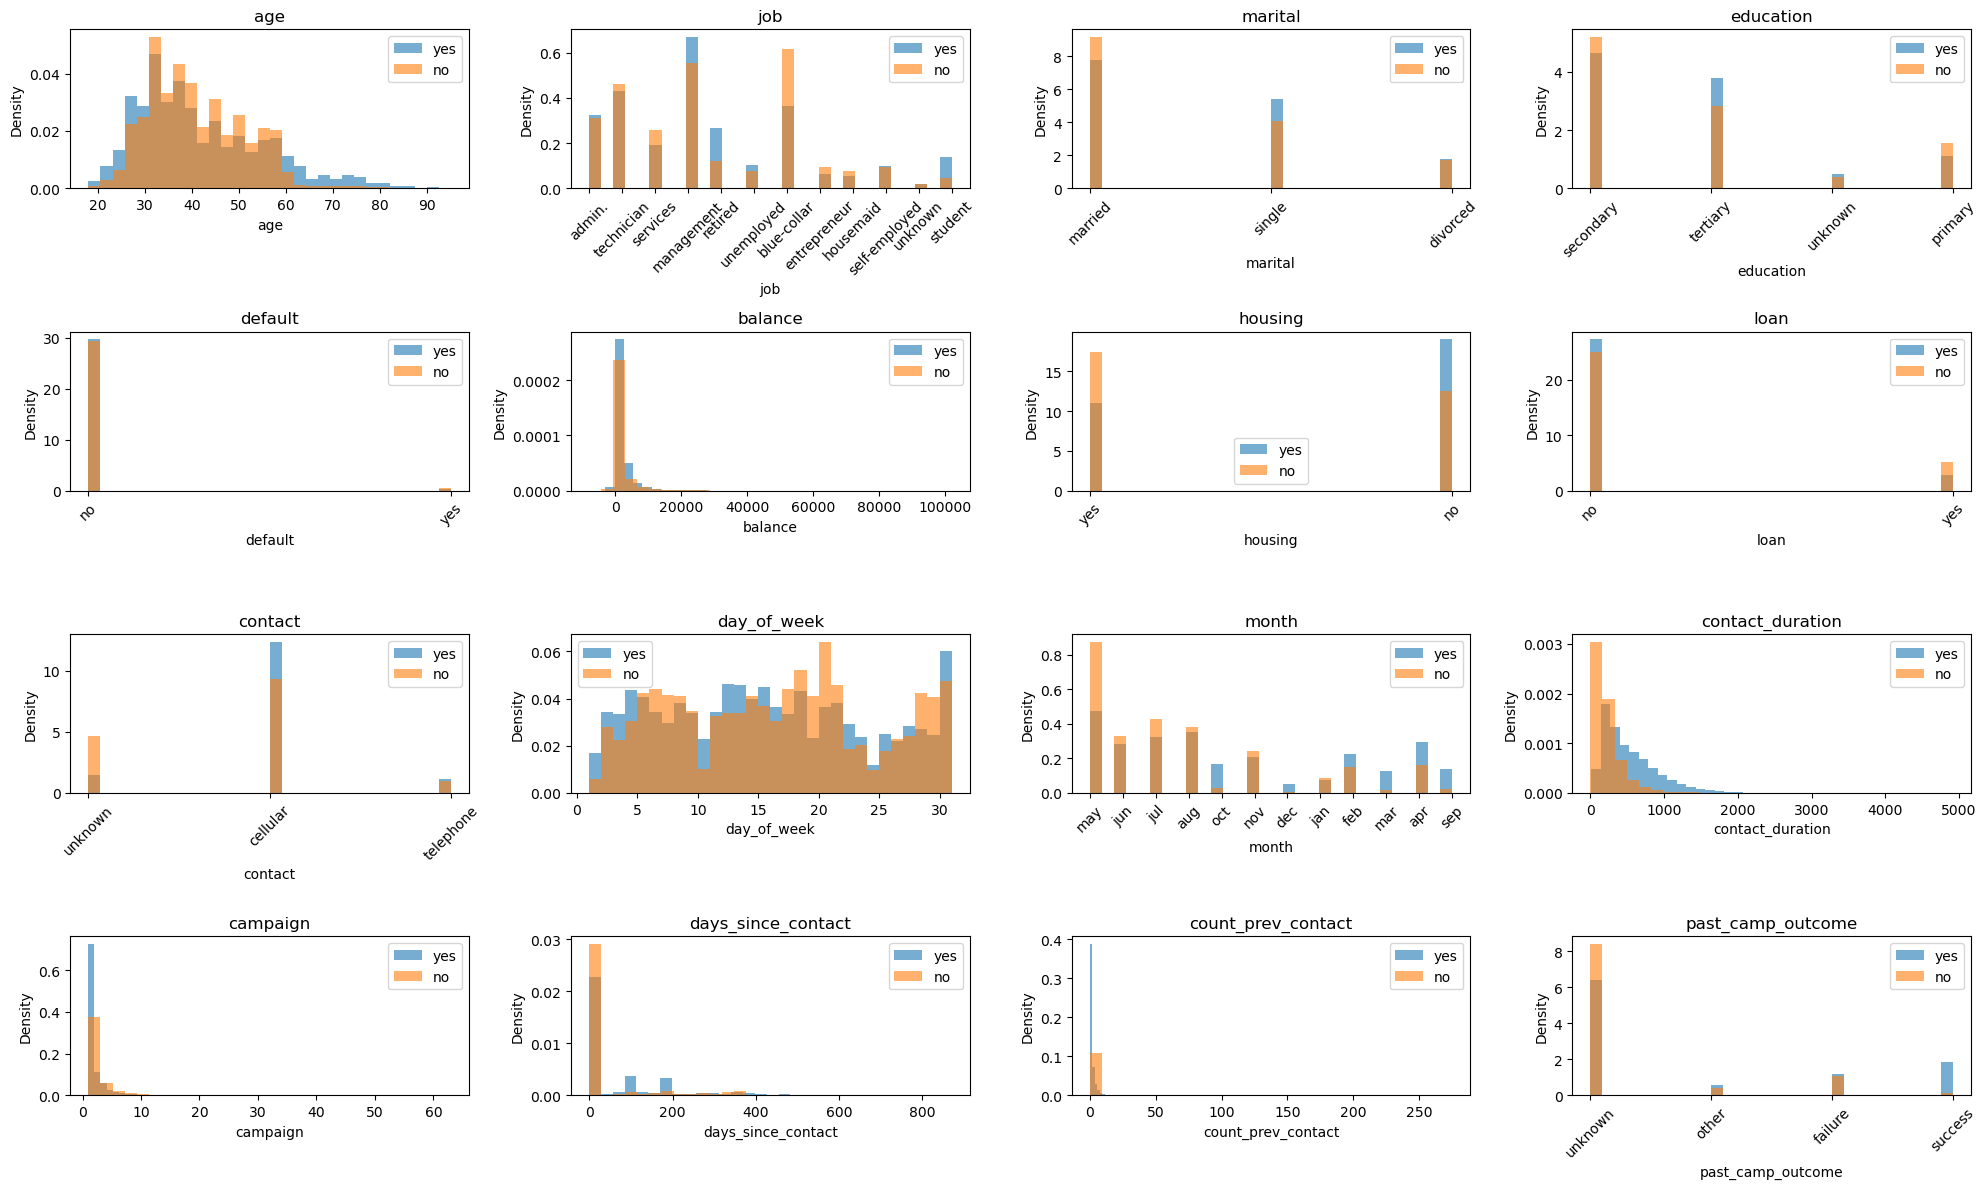

In [8]:

# looking at each feature distribution with regard to the target term deposit

cols = df.columns[:-1]  # All features except 'term_deposit'
n_cols = 4  # Number of subplots per row
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    
    ax.hist(df[df['term_deposit'] == 'yes'][col], bins=30, alpha=0.6, label='yes', density=True)
    ax.hist(df[df['term_deposit'] == 'no'][col], bins=30, alpha=0.6, label='no', density=True)
    
    ax.set_title(f'{col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend()
    
    # Flip x-axis labels if categorical
    if df[col].dtype == 'object' or df[col].nunique() < 15:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
df.term_deposit.value_counts()
# this is unbalanced class, I will need to over sample the data for classification

term_deposit
no     39922
yes     5289
Name: count, dtype: int64

### Preprocessing (Encoding)

Mapping

In [10]:
# looking at the job, contact, past_camp_outcome feature looks like I will have to use one hot encoding with it
# martital doesnt actually have inherent odrder to them despite intution so also one hot ecncoding
# education on the otherhand has inherent order to them so I will use label encoding
# default, housing , loan, term_deposit will be handeled with just mapping
# month is tricky because it will impact different learning models differently based on the way I handle it  # tree, XGBoost models would be generally good with these

# mapping the yes and no
df_try= df.copy()

columns_to_map = ['default', 'housing', 'loan', 'term_deposit']
mapping= {'yes': 1 , 'no' : 0}

df_try['default']= df_try['default'].map(mapping)
df_try['term_deposit']= df_try['term_deposit'].map(mapping)
df_try['housing']= df_try['housing'].map(mapping)
df_try['loan']= df_try['loan'].map(mapping)

df_try[columns_to_map]


,default,housing,loan,term_deposit
0,0,1,0,0
1,0,1,0,0
2,0,1,1,0
3,0,1,0,0
4,0,0,0,0
...,...,...,...,...
45206,0,0,0,1
45207,0,0,0,1
45208,0,0,0,1
45209,0,0,0,0


Inherent Order

In [11]:
# label encoding education as its ordinal (unknown might be tricky but I will assign it at the begining or at the end)
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
df_try['education']= le.fit_transform(df_try['education'].astype(str))
label_encoder= le

df_try['education'].value_counts()


education
1    23202
2    13301
0     6851
3     1857
Name: count, dtype: int64

In [12]:
df['education'].value_counts()


education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

No Inherent Order

In [13]:
df_try.shape

(45211, 17)

In [14]:
# using one hot-encoding I will deal with marital, job, contact, past_camp_outcome features

columns_to_ohe = ['marital', 'job', 'contact', 'past_camp_outcome']

from sklearn.preprocessing import OneHotEncoder

hot= OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = hot.fit_transform(df_try[columns_to_ohe].astype(str))  # transforming the values
encoded_features_names = hot.get_feature_names_out(columns_to_ohe)  # getting the names of the encoded columns

one_df= pd.DataFrame(encoded_features, columns= encoded_features_names, index=df_try.index)  # DataFrame from the encoded features

# drop the old not encoded columns and adding the new encoded ones
df_try = df_try.drop(columns= columns_to_ohe)
df_try = pd.concat([df_try,one_df], axis= 1)

In [15]:
df_try.head()
# I need to work on the month and deal with the original numeric through scaling them if needed

,age,education,default,balance,housing,loan,day_of_week,month,contact_duration,campaign,...,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown,past_camp_outcome_failure,past_camp_outcome_other,past_camp_outcome_success,past_camp_outcome_unknown
0,58,2,0,2143,1,0,5,may,261,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,44,1,0,29,1,0,5,may,151,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33,1,0,2,1,1,5,may,76,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,47,3,0,1506,1,0,5,may,92,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,33,3,0,1,0,0,5,may,198,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
print(df_try.shape)

(45211, 35)


cyclical encoding for seasonality (cyclical feature transformation)

Text(0.5, 1.0, 'Term Deposit Sub vs. Last Day Contacted')

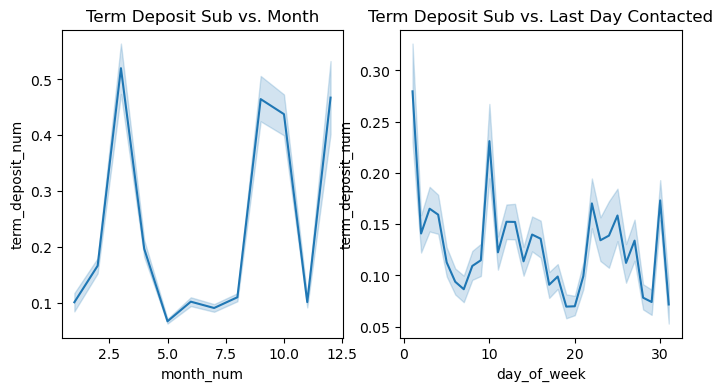

In [17]:
# now the last object remaining in the dataframe is the month and I want to see if it's seasonal or not to decide how to deal with it

# Map month names to numbers (assuming lower case as in your data)
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
			 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df_viz= df.copy()
df_viz['month_num'] = df['month'].map(month_map)

# Convert term_deposit to numeric for plotting
df_viz['term_deposit_num'] = df_viz['term_deposit'].map({'yes': 1, 'no': 0})

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.lineplot(x='month_num', y='term_deposit_num', data=df_viz, ax=ax[0])
sns.lineplot(x='day_of_week', y='term_deposit_num', data=df_viz, ax=ax[1])
ax[0].set_title("Term Deposit Sub vs. Month")
ax[1].set_title("Term Deposit Sub vs. Last Day Contacted")

# it seems that the month feature is seasonal but the day doesn't make sense to be seasonal

In [18]:

# cyclical encoding for the month feature (this scales it between -1, 1 as well)
df_try['month_sin'] = np.sin(2 * np.pi * df_viz['month_num'] / 12)
df_try['month_cos'] = np.cos(2 * np.pi * df_viz['month_num'] / 12)


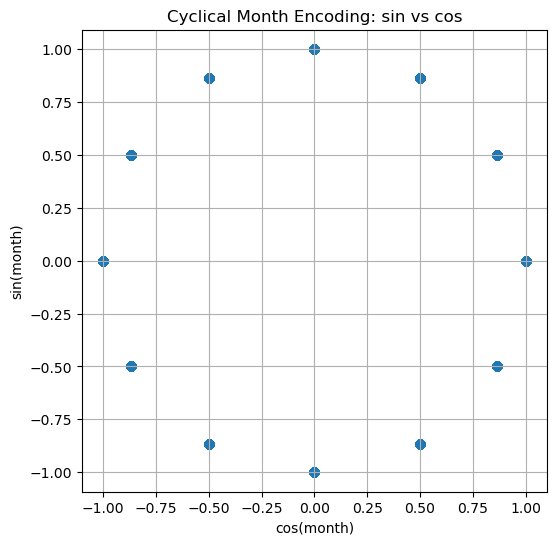

In [19]:

plt.figure(figsize=(6, 6))
plt.scatter(df_try['month_cos'], df_try['month_sin'], alpha=0.7)
plt.title("Cyclical Month Encoding: sin vs cos")
plt.xlabel("cos(month)")
plt.ylabel("sin(month)")
plt.grid(True)
plt.axis('equal')
plt.show()

# circle so there is no issue in the encoding

### Train, Test Split

In [20]:
X= df_try.drop(columns= ['contact_duration', 'month', 'term_deposit'])
y= df_try['term_deposit']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2)

### Preprocessing (Scaling)

looking at the features

In [22]:
df_try[df_try.columns[:12]] 

# scaling depends on the models that I am gonna use for example tree model wouldn't need it but for models like Logistic Regression, SVM , KNN , Neural Nets I should scale 
# because it's really skewed and dominate the model if not scaled
# campaign will need to be scaled
# day of week maybe scale it or use cyclical encode (dont leave like this)

,age,education,default,balance,housing,loan,day_of_week,month,contact_duration,campaign,days_since_contact,count_prev_contact
0,58,2,0,2143,1,0,5,may,261,1,-1,0
1,44,1,0,29,1,0,5,may,151,1,-1,0
2,33,1,0,2,1,1,5,may,76,1,-1,0
3,47,3,0,1506,1,0,5,may,92,1,-1,0
4,33,3,0,1,0,0,5,may,198,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,2,0,825,0,0,17,nov,977,3,-1,0
45207,71,0,0,1729,0,0,17,nov,456,2,-1,0
45208,72,1,0,5715,0,0,17,nov,1127,5,184,3
45209,57,1,0,668,0,0,17,nov,508,4,-1,0


In [23]:
df_try.campaign.value_counts()

campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: count, dtype: int64

In [24]:
df_try['count_prev_contact'].value_counts()

count_prev_contact
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: count, dtype: int64

In [25]:
df_try.balance.value_counts()

balance
 0        3514
 1         195
 2         156
 4         139
 3         134
          ... 
-381         1
 4617        1
 20584       1
 4358        1
 16353       1
Name: count, Length: 7168, dtype: int64

In [26]:
columns_to_scale= ['day_of_week', 'campaign', 'count_prev_contact', 'balance']

In [27]:
X_train[columns_to_scale].max()

day_of_week              31
campaign                 58
count_prev_contact       38
balance               66721
dtype: int64

In [28]:
X_train['balance'].min()


-4057

In [29]:
X_train[columns_to_scale].skew()


day_of_week           0.087506
campaign              5.268371
count_prev_contact    6.787327
balance               6.998463
dtype: float64

In [30]:
# this is for checking for any errors before and after running the sampler log and scaler
print(np.isinf(X_train[columns_to_scale]).sum())

print(X_train[columns_to_scale].isna().sum())


day_of_week           0
campaign              0
count_prev_contact    0
balance               0
dtype: int64
day_of_week           0
campaign              0
count_prev_contact    0
balance               0
dtype: int64


In [31]:
# Cap original balance values to 99th percentile before log (to remove outliers before running log)
#cap = X_train['balance'].quantile(0.99)
#X_train['balance'] = X_train['balance'].clip(upper=cap)
#X_test['balance'] = X_test['balance'].clip(upper=cap)


In [32]:
X_train[columns_to_scale].skew()


day_of_week           0.087506
campaign              5.268371
count_prev_contact    6.787327
balance               6.998463
dtype: float64

Oversampling and Scaling

In [33]:
# resampling the data t deal with the unbalanced class problem
from imblearn.over_sampling import RandomOverSampler

ros= RandomOverSampler()
X_train, y_train= ros.fit_resample(X_train, y_train)

# log transformation reduces the skeweness to a smoother, more usable shape.
# X_train[columns_to_scale] = np.log1p(X_train[columns_to_scale])
# X_test[columns_to_scale] = np.log1p(X_test[columns_to_scale])

# scaling the data
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [34]:
# Replace inf/-inf with NaN
#X_train[columns_to_scale] = X_train[columns_to_scale].replace([np.inf, -np.inf], np.nan)

# Option 1: Drop rows with NaNs (careful if dataset is small)
#X_train = X_train.dropna(subset=columns_to_scale)

# Option 2: Fill NaNs with median (safer for modeling)
#for col in columns_to_scale:
#    median = X_train[col].median()
#    X_train[col].fillna(median, inplace=True)
#    X_test[col].fillna(median, inplace=True)  # Do the same to test set
#

In [35]:
# this is for checking for any errors before and after running the sampler log and scaler
print(np.isinf(X_train[columns_to_scale]).sum())

print(X_train[columns_to_scale].isna().sum())
# if nans and inf aris I will skip the log step and just use tree and xgboost models
# Just skip log1p and don’t scale balance — especially when using tree-based models.

day_of_week           0
campaign              0
count_prev_contact    0
balance               0
dtype: int64
day_of_week           0
campaign              0
count_prev_contact    0
balance               0
dtype: int64


I am thinking that tree model and xgboost would give the best prediction but lets see

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [37]:
classifiers= {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBclassifier': XGBClassifier(),
    'Support Vector Classifier': SVC(probability=True)
}

for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification report for {name}:")
    print('==================================================')
    print(classification_report(y_test, y_pred))

# rf is the best model but the score is not enough

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     31897
           1       0.22      0.66      0.33      4272

    accuracy                           0.69     36169
   macro avg       0.58      0.68      0.56     36169
weighted avg       0.85      0.69      0.74     36169

Classification report for K-Nearest Neighbor:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     31897
           1       0.24      0.38      0.29      4272

    accuracy                           0.78     36169
   macro avg       0.57      0.61      0.58     36169
weighted avg       0.83      0.78      0.80     36169

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     31897
           1       0.28      0.27      0.27      4272

    accuracy                           0.83     

maybe if the balance feature didn't have that massive of a range from negative to a positive, I could've applied the log and maybe would have gotten better predictions with other models (other than XGboost, tree and forest). 

honestly I should have noticed that from the start rather that after I got the error.

### The results
- The best model was **Random forest** with 89% accuracy and 0.51 precision , 0.30 recall for the minority class
- XGBClassifier was the second in terms of accuracy 84% and   0.36 precision,  0.46 recall
- Support Vector Machine with 83%
- Decision Tree with 83%
- K-Nearest Neighbor with 78%
- Logistic Regression with 70%